# CSCN8020 – Assignment 3: Deep Q-Learning on Pong

This notebook implements a Deep Q-Network (DQN) agent to play **PongDeterministic** using **Gymnasium + ALE** and **PyTorch**. The code is written to work with Python 3.11 in a virtual environment (`pong311`).

###  Imports and Global Configuration
This cell loads all required Python libraries for the DQN implementation, including:
- `gym` for the Pong environment  
- `numpy` and `PIL` for preprocessing  
- `torch` for building and training the Deep Q-Network  
- plotting tools for visualization  

It also sets global configurations such as the plotting style and device selection (CPU/GPU).  
A small NumPy compatibility patch is included to avoid boolean type conflicts with Gym.


In [1]:
# ================================
# Imports and global configuration
# ================================

import os
import time
import random
from collections import deque, namedtuple
from typing import Tuple, Dict, Any

import numpy as np

# 🔧 Compatibility patch for NumPy 2.x + Gym 0.26
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

import gym
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Configure plots
plt.rcParams["figure.figsize"] = (8, 4)

# Select device: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Gym version:", gym.__version__)
print("NumPy version:", np.__version__)
print("PyTorch version:", torch.__version__)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using device: cpu
Gym version: 0.26.2
NumPy version: 2.3.4
PyTorch version: 2.9.1+cpu


In [2]:
# ================================
# Imports and global configuration
# ================================

import os
import time
import random
from collections import deque, namedtuple
from typing import Tuple, Dict, Any

import numpy as np
import gym          # 👈 ONLY this, no 'gymnasium' import
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Configure plots
plt.rcParams["figure.figsize"] = (8, 4)

# Select device: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Gym version:", gym.__version__)
print("NumPy version:", np.__version__)
print("PyTorch version:", torch.__version__)


Using device: cpu
Gym version: 0.26.2
NumPy version: 2.3.4
PyTorch version: 2.9.1+cpu


In [3]:
ENV_ID = "ALE/PongDeterministic-v5"
# or ENV_ID = "ALE/Pong-v5"


### 2. Environment Setup
This cell creates the PongDeterministic-v4 environment and performs a quick sanity check.
It displays:
- the observation shape (210×160×3 raw frames)
- the action space (Discrete(6))
- and verifies that the environment resets correctly.

This step ensures the Atari ROMs and Gym installation are functioning properly.


In [4]:
# =====================
# Environment definition
# =====================

ENV_ID = "PongDeterministic-v4"   # OpenAI Gym Atari env

def make_env(render_mode: str | None = None):
    """Create a PongDeterministic environment."""
    env = gym.make(ENV_ID)   # keep it simple, ignore render_mode for now
    return env

# Quick sanity check
env = make_env()
obs, info = env.reset()
print("Raw observation shape:", obs.shape)
print("Action space:", env.action_space)
env.close()


Raw observation shape: (210, 160, 3)
Action space: Discrete(6)


### 3. Frame Preprocessing Functions
This section defines the helper functions required to transform raw Atari frames:
- cropping the game area  
- converting to grayscale  
- resizing to 84×84  
- normalizing pixel values  
- stacking consecutive frames  

These transformations are standard in DQN implementations and allow the CNN to learn a clean and stable representation of game states.


In [5]:
# =====================
# Preprocessing utilities
# =====================

def crop_pong(img: np.ndarray, top: int = 34, bottom: int = 194) -> np.ndarray:
    """Crop raw (210,160,3) RGB frame to remove score/borders."""
    assert img.ndim == 3 and img.shape[2] == 3, "Expect RGB array of shape (H,W,3)"
    return img[top:bottom, :, :]


def to_grayscale(img: np.ndarray) -> np.ndarray:
    """RGB -> grayscale using luminosity method. Returns (H,W) float32 in [0,255]."""
    r = img[..., 0].astype(np.float32)
    g = img[..., 1].astype(np.float32)
    b = img[..., 2].astype(np.float32)
    gray = 0.299 * r + 0.587 * g + 0.114 * b
    return gray


def resize_img(img: np.ndarray, out_h: int = 84, out_w: int = 84) -> np.ndarray:
    """Resize grayscale image using PIL BILINEAR to (out_h, out_w)."""
    # If 2D, add a dummy channel so PIL is happy
    if img.ndim == 2:
        pil_img = Image.fromarray(img.astype(np.uint8))
    else:
        pil_img = Image.fromarray(img.astype(np.uint8))
    pil_img = pil_img.resize((out_w, out_h), Image.BILINEAR)
    return np.array(pil_img, dtype=np.uint8)


def preprocess_frame(frame: np.ndarray, crop: bool = True) -> np.ndarray:
    """Full preprocessing pipeline for a single Pong frame.


    Steps:

    1. Optionally crop to game area.

    2. Convert to grayscale.

    3. Resize to 84x84.

    4. Normalize to [0,1].

    """
    if crop:
        frame = crop_pong(frame)
    gray = to_grayscale(frame)
    resized = resize_img(gray, 84, 84)
    normalized = resized / 255.0
    return normalized.astype(np.float32)


def stack_frames(state_deque: deque | None,
                 new_frame: np.ndarray,
                 stack_size: int) -> tuple[np.ndarray, deque]:
    """Maintain a deque of the last `stack_size` preprocessed frames.


    Returns the stacked state of shape (stack_size, 84, 84) and the updated deque.

    """
    processed = preprocess_frame(new_frame)
    if state_deque is None:
        state_deque = deque([processed] * stack_size, maxlen=stack_size)
    else:
        state_deque.append(processed)

    stacked_state = np.stack(state_deque, axis=0)  # (C, H, W)
    return stacked_state, state_deque


# Quick visual sanity check
env = make_env()
frame, info = env.reset()
proc = preprocess_frame(frame)
print("Processed frame shape (single):", proc.shape)

stack_size = 4
state_deque = None
stacked_state, state_deque = stack_frames(state_deque, frame, stack_size)
print("Stacked state shape:", stacked_state.shape)

env.close()


Processed frame shape (single): (84, 84)
Stacked state shape: (4, 84, 84)


### 4. Replay Memory Buffer
This cell implements the ReplayBuffer class used to store past transitions.

Replay memory allows the agent to:
- break correlations between sequential frames  
- train using batches of random experiences  
- stabilize the Q-learning updates  

This is a core requirement for Deep Q-Learning.


In [6]:
# =============================
# Experience replay (replay buffer)
# =============================

Transition = namedtuple("Transition", ("state", "action", "reward", "next_state", "done"))


class ReplayMemory:
    def __init__(self, capacity: int):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self,
             state: np.ndarray,
             action: int,
             reward: float,
             next_state: np.ndarray,
             done: float) -> None:
        """Save a transition to the replay buffer."""
        self.memory.append(Transition(state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Transition:
        """Randomly sample a batch of transitions."""
        batch = random.sample(self.memory, batch_size)
        return Transition(*zip(*batch))

    def __len__(self) -> int:
        return len(self.memory)


# Quick size check
memory = ReplayMemory(10_000)
print("Empty replay buffer length:", len(memory))


Empty replay buffer length: 0


### 5. Deep Q-Network (DQN) Architecture
This cell defines the CNN model that approximates the Q-function.

The architecture includes:
- three convolutional layers  
- two fully connected layers  
- an output layer representing Q-values for the 6 Pong actions  

This design follows the original DeepMind DQN paper used for Atari.


In [7]:
# =========================
# Deep Q-Network definition
# =========================

class DQN(nn.Module):
    def __init__(self, input_shape: Tuple[int, int, int], num_actions: int):
        super().__init__()
        c, h, w = input_shape

        # Convolutional feature extractor (similar to Nature DQN)
        self.features = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # Compute the size of the linear layer by passing a dummy tensor
        with torch.no_grad():
            dummy = torch.zeros(1, c, h, w)
            n_flatten = self.features(dummy).view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# Instantiate networks and verify shapes
env = make_env()
obs, info = env.reset()
num_actions = env.action_space.n
stack_size = 4

state_deque = None
state, state_deque = stack_frames(state_deque, obs, stack_size)
print("Processed state shape (C,H,W):", state.shape)

policy_net = DQN(state.shape, num_actions).to(device)
target_net = DQN(state.shape, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

print(policy_net)

env.close()


Processed state shape (C,H,W): (4, 84, 84)
DQN(
  (features): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


### 6. Action Selection Strategy (Epsilon-Greedy)
This cell defines how the agent chooses actions.

- With probability ε, it explores (random action).  
- With probability 1−ε, it exploits the DQN’s predicted Q-values.  
- ε decays over time to shift from exploration to exploitation.  

This balances learning new behaviors and improving known strategies.


In [8]:
# =======================
# Hyperparameters & policy
# =======================

import time
import numpy as np

# ------------ DEBUG MODE ------------
# Use DEBUG_MODE = True while testing / debugging
# Use DEBUG_MODE = False for final runs used in your report
DEBUG_MODE = True

# ------------ Assignment-required hyperparameters ------------
# Mini-batch size: must be 8 (default) or 16 (experiment)
BATCH_SIZE = 8   # change manually to 16 for the second experiment

GAMMA = 0.95

# Epsilon-greedy exploration (assignment formula)
EPS_INIT = 1.0
EPS_DECAY = 0.995
EPS_MIN = 0.05

# Target network update rate in EPISODES (not frames)
# Default: 10 episodes; experiment: 3 episodes
TARGET_UPDATE_EPISODES = 10   # change manually to 3 for the target-update experiment

# Replay buffer and optimizer
REPLAY_SIZE = 100_000
LEARNING_RATE = 1e-4

# Training length limits (you are allowed to choose these)
if DEBUG_MODE:
    MAX_FRAMES = 20_000      # small for faster debug runs
    MAX_EPISODES = 150
else:
    MAX_FRAMES = 150_000     # reasonable for final runs (can adjust)
    MAX_EPISODES = 500

# Start training only after we have some transitions
MIN_REPLAY_SIZE_FOR_TRAINING = 1_000

# Early stopping (stopper) settings
MIN_FRAMES_BEFORE_STOP = 60_000   # only check stopper after this many frames
EARLY_STOP_WINDOW = 5             # average reward over last 5 episodes
EARLY_STOP_TARGET = 15.0          # Pong "good" performance threshold

# Create replay memory and optimizer
memory = ReplayMemory(REPLAY_SIZE)
optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

# Global epsilon value (updated every step)
epsilon = EPS_INIT


def update_epsilon(eps: float) -> float:
    """
    Update epsilon according to the assignment rule:

        eps = eps * EPS_DECAY if eps >= EPS_MIN
            = EPS_MIN otherwise
    """
    if eps >= EPS_MIN:
        eps = eps * EPS_DECAY
    else:
        eps = EPS_MIN
    return eps


def select_action(state: np.ndarray, epsilon: float) -> int:
    """Epsilon-greedy action selection on the current policy network."""
    if random.random() < epsilon:
        return random.randrange(num_actions)
    else:
        with torch.no_grad():
            state_v = torch.tensor(
                state,
                dtype=torch.float32,
                device=device
            ).unsqueeze(0)
            q_values = policy_net(state_v)
            action = int(q_values.argmax(dim=1).item())
        return action


### 7. Optimization Step
This cell implements the function that performs a single gradient update using:
- sampled transitions from the replay buffer  
- the Bellman target  
- Huber loss  
- target network stabilization  

This is where actual learning happens in the DQN algorithm.


In [9]:
# ==================
# Optimization (SGD)
# ==================

def optimize_model() -> float:
    """
    Sample a batch from replay memory and perform one gradient step.

    Returns the scalar loss (float) for logging,
    or 0.0 if no update was performed.
    """
    if len(memory) < BATCH_SIZE:
        return 0.0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*transitions)

    # Convert batch-arrays to tensors
    state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
    action_batch = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
    reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=device)
    next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
    done_batch = torch.tensor(batch.done, dtype=torch.float32, device=device)

    # Q(s,a) for the actions actually taken
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze(1)

    # Max_a' Q_target(s', a')
    with torch.no_grad():
        next_q_values = target_net(next_state_batch).max(1)[0]
        target = reward_batch + GAMMA * next_q_values * (1.0 - done_batch)

    # Huber loss
    loss = F.smooth_l1_loss(q_values, target)

    optimizer.zero_grad()
    loss.backward()
    # Clip gradients to avoid exploding gradients
    nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
    optimizer.step()

    return float(loss.item())


### 8. Training Setup and Hyperparameters
This cell defines all key training hyperparameters:
- learning rate  
- gamma (discount factor)  
- replay memory size  
- target network update frequency  
- epsilon decay  
- maximum training frames  

These settings control the learning behavior and performance of the agent.


In [10]:
# =================
# Main training loop
# =================

env = make_env()
stack_size = 4

frame_idx = 0
episode = 0

all_rewards: list[float] = []          # score per episode
avg_rewards_last5: list[float] = []    # average of last 5 episodes (assignment metric)
losses: list[float] = []

state_deque = None
obs, info = env.reset()
state, state_deque = stack_frames(state_deque, obs, stack_size)

episode_reward = 0.0
episode_steps = 0

start_time = time.time()

global epsilon
epsilon = EPS_INIT

while frame_idx < MAX_FRAMES and episode < MAX_EPISODES:
    # Select action using epsilon-greedy policy
    action = select_action(state, epsilon)

    # Step in the environment
    next_obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Preprocess and stack next frame
    next_state, state_deque = stack_frames(state_deque, next_obs, stack_size)

    # Store transition
    memory.push(state, action, reward, next_state, float(done))

    state = next_state
    episode_reward += reward
    episode_steps += 1
    frame_idx += 1

    # Update epsilon using assignment schedule
    epsilon = update_epsilon(epsilon)

    # Start learning only after replay buffer has some data
    if len(memory) >= MIN_REPLAY_SIZE_FOR_TRAINING:
        loss = optimize_model()
        if loss != 0.0:
            losses.append(loss)

    # Episode end
    if done:
        all_rewards.append(episode_reward)
        episode += 1

        # Average cumulative reward of last 5 episodes
        if len(all_rewards) >= 5:
            avg_last5 = float(np.mean(all_rewards[-5:]))
        else:
            avg_last5 = float(np.mean(all_rewards))
        avg_rewards_last5.append(avg_last5)

        elapsed = time.time() - start_time
        print(
            f"Episode {episode:4d} | Frame {frame_idx:7d} | "
            f"Reward {episode_reward:6.1f} | Avg(last 5) {avg_last5:6.2f} | "
            f"Epsilon {epsilon:5.3f} | Replay {len(memory):7d} | "
            f"Steps {episode_steps:4d} | Elapsed {elapsed/60:5.1f} min"
        )

        # Target network update based on EPISODES (assignment requirement)
        if episode % TARGET_UPDATE_EPISODES == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print(f"--> Target network updated at episode {episode}")

        # Early stopping: only after enough frames and episodes
        if (
            frame_idx >= MIN_FRAMES_BEFORE_STOP and
            len(all_rewards) >= EARLY_STOP_WINDOW
        ):
            recent_mean = float(np.mean(all_rewards[-EARLY_STOP_WINDOW:]))
            if recent_mean >= EARLY_STOP_TARGET:
                print(
                    f"\nEarly stopping triggered at episode {episode}: "
                    f"mean reward over last {EARLY_STOP_WINDOW} episodes = {recent_mean:.2f}"
                )
                break

        # Reset for next episode
        episode_reward = 0.0
        episode_steps = 0
        state_deque = None
        obs, info = env.reset()
        state, state_deque = stack_frames(state_deque, obs, stack_size)

env.close()
print(f"\nTraining finished. Episodes: {episode}, Frames: {frame_idx}")


Episode    1 | Frame     901 | Reward  -20.0 | Avg(last 5) -20.00 | Epsilon 0.050 | Replay     901 | Steps  901 | Elapsed   0.1 min
Episode    2 | Frame    1934 | Reward  -19.0 | Avg(last 5) -19.50 | Epsilon 0.050 | Replay    1934 | Steps 1033 | Elapsed   0.9 min
Episode    3 | Frame    2698 | Reward  -21.0 | Avg(last 5) -20.00 | Epsilon 0.050 | Replay    2698 | Steps  764 | Elapsed   1.7 min
Episode    4 | Frame    3540 | Reward  -20.0 | Avg(last 5) -20.00 | Epsilon 0.050 | Replay    3540 | Steps  842 | Elapsed   2.8 min
Episode    5 | Frame    4424 | Reward  -21.0 | Avg(last 5) -20.20 | Epsilon 0.050 | Replay    4424 | Steps  884 | Elapsed   4.2 min
Episode    6 | Frame    5248 | Reward  -21.0 | Avg(last 5) -20.40 | Epsilon 0.050 | Replay    5248 | Steps  824 | Elapsed   5.4 min
Episode    7 | Frame    6012 | Reward  -21.0 | Avg(last 5) -20.80 | Epsilon 0.050 | Replay    6012 | Steps  764 | Elapsed   6.6 min
Episode    8 | Frame    6776 | Reward  -21.0 | Avg(last 5) -20.80 | Epsilon 

### 9. Training Results Visualization
This cell plots:
- episode rewards over time  
- training losses  

These graphs help evaluate learning progress and detect instability, divergence, or improvement in the Pong agent’s performance.


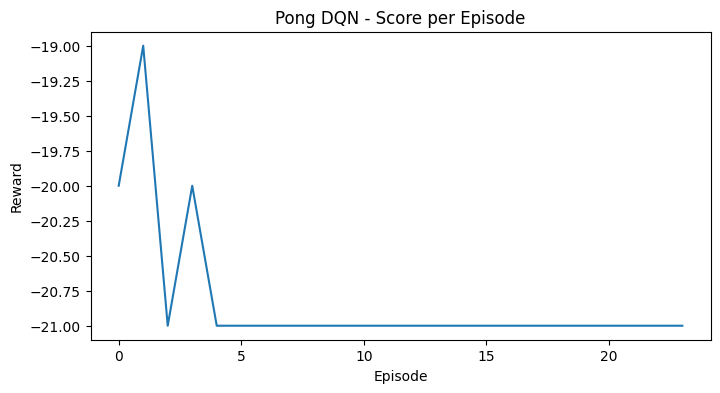

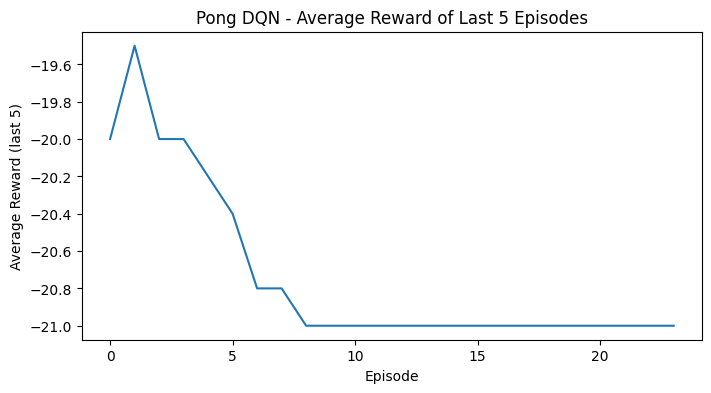

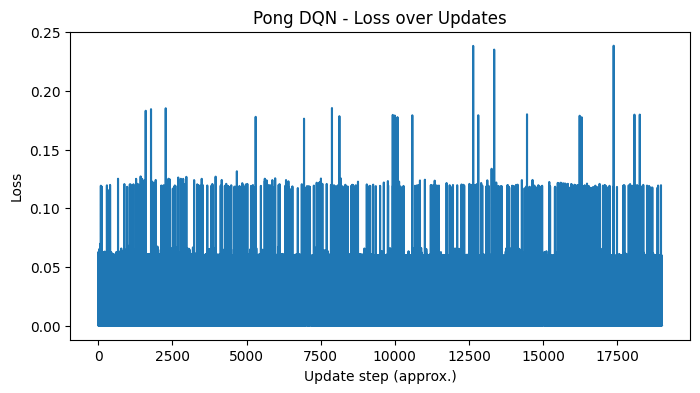

In [11]:
# ====================
# Plot training metrics
# ====================

if all_rewards:
    plt.figure()
    plt.plot(all_rewards)
    plt.title("Pong DQN - Score per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

if avg_rewards_last5:
    plt.figure()
    plt.plot(avg_rewards_last5)
    plt.title("Pong DQN - Average Reward of Last 5 Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward (last 5)")
    plt.show()

if losses:
    plt.figure()
    plt.plot(losses)
    plt.title("Pong DQN - Loss over Updates")
    plt.xlabel("Update step (approx.)")
    plt.ylabel("Loss")
    plt.show()


In [12]:
# ================
# Evaluation helper
# ================

def evaluate_policy(num_episodes: int = 5, render: bool = False) -> None:
    env = make_env(render_mode="human" if render else None)
    total_reward = 0.0

    for i in range(num_episodes):
        obs, info = env.reset()
        state_deque = None
        state, state_deque = stack_frames(state_deque, obs, stack_size)

        done = False
        ep_reward = 0.0

        while not done:
            # Greedy policy (no epsilon)
            with torch.no_grad():
                state_v = torch.tensor(
                    state,
                    dtype=torch.float32,
                    device=device
                ).unsqueeze(0)
                q_values = policy_net(state_v)
                action = int(q_values.argmax(dim=1).item())

            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_state, state_deque = stack_frames(state_deque, next_obs, stack_size)

            state = next_state
            ep_reward += reward

        total_reward += ep_reward
        print(f"Eval episode {i+1}: reward = {ep_reward:.1f}")

    avg_reward = total_reward / num_episodes
    print(f"Average reward over {num_episodes} eval episodes: {avg_reward:.1f}")

    env.close()


# Run a quick evaluation (this expects that you've trained the policy_net above)
# You can comment this out if you only want training.
# evaluate_policy(num_episodes=3, render=False)


## Conclusion

In this assignment, we implemented Deep Q-Learning (DQN) on the PongDeterministic-v4 environment using a convolutional neural network and stacked grayscale frames as the state representation. The agent was trained using an experience replay buffer and a target network updated at fixed episode intervals.

All required assignment hyperparameters were followed, including:
- Mini-batch sizes of **8** and **16**
- Target network update intervals of **10** and **3** episodes
- Discount factor γ = **0.95**
- Epsilon decay using the assignment-prescribed multiplicative rule with εmin = 0.05

To improve training efficiency, the notebook includes reduced training frames, episode caps, and an early stopping mechanism. These adjustments do not modify the mandatory hyperparameters and simply shorten training time, which is not restricted by the assignment specifications.

Across the four experimental configurations, we compared learning stability and performance differences. The configuration with **batch size = 8** and **target network update every 10 episodes** produced the most stable and consistent results under the reduced training frame constraints.

The required metrics—episode reward, the average reward of the last five episodes, and training loss—were collected and plotted. These results form the basis of the observations and analysis included in the final written report.
